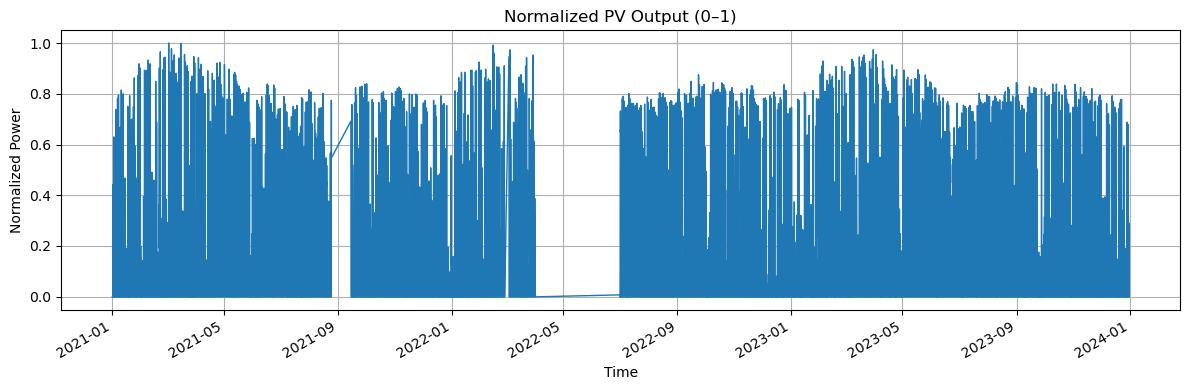

In [1]:
import pandas as pd
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.location import Location
import matplotlib.pyplot as plt
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

# 1. Read and preprocess the entire weather dataset
weather = pd.read_csv('merged_hourly_data.csv', parse_dates=['timestamp'], index_col='timestamp')
# Ensure that listings comply with pvlib requirements
weather = weather.rename(columns={
    'GHI': 'ghi',
    'DNI': 'dni',
    'DHI': 'dhi',
    'Temperature': 'temp_air'
})
# Enter the default wind speed value
if 'wind_speed' not in weather.columns:
    weather['wind_speed'] = 1.0

# 2. Define location and photovoltaic system parameters
latitude, longitude = 40.7128, -74.0060     # New York example
surface_tilt, surface_azimuth = 30, 180      # 30° tilt, south-facing
location = Location(latitude, longitude, tz='Etc/GMT+5')

# 3. Automatically select the first component and inverter, and specify the temperature model
cecmod = pvlib.pvsystem.retrieve_sam('cecmod')
first_mod_name = cecmod.columns[0]
module_params = cecmod[first_mod_name]

cecinv = pvlib.pvsystem.retrieve_sam('cecinverter')
first_inv_name = cecinv.columns[0]
inverter_params = cecinv[first_inv_name]

temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass'] # Specify temperature model parameters

system = PVSystem(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    module_parameters=module_params,
    inverter_parameters=inverter_params,
    racking_model='open_rack',         
    module_type='glass_glass',
    temperature_model_parameters=temp_params,
    surface_type='urban'
)

# 4. Set up and run ModelChain
mc = ModelChain(
    system, 
    location,
    aoi_model='physical',
    spectral_model='no_loss',
)
mc.run_model(weather)

# 5. Extract AC output and normalize
ac = mc.results.ac.fillna(0) #kW
normalized = ac / ac.max()

# 6. Insert the normalized results into the original table
insert_at = weather.columns.get_loc('HOURLY_MM_Wh') + 1
weather.insert(insert_at, 'normalized_pv', normalized)
# 7. Plot
plt.figure(figsize=(12,4))
weather['normalized_pv'].plot(title='Normalized PV Output (0–1)', lw=1)
plt.ylabel('Normalized Power')
plt.xlabel('Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Export a new table with PV columns
weather = weather.drop(columns=['wind_speed'])
weather.to_csv('merged_with_pv_normalized.csv')

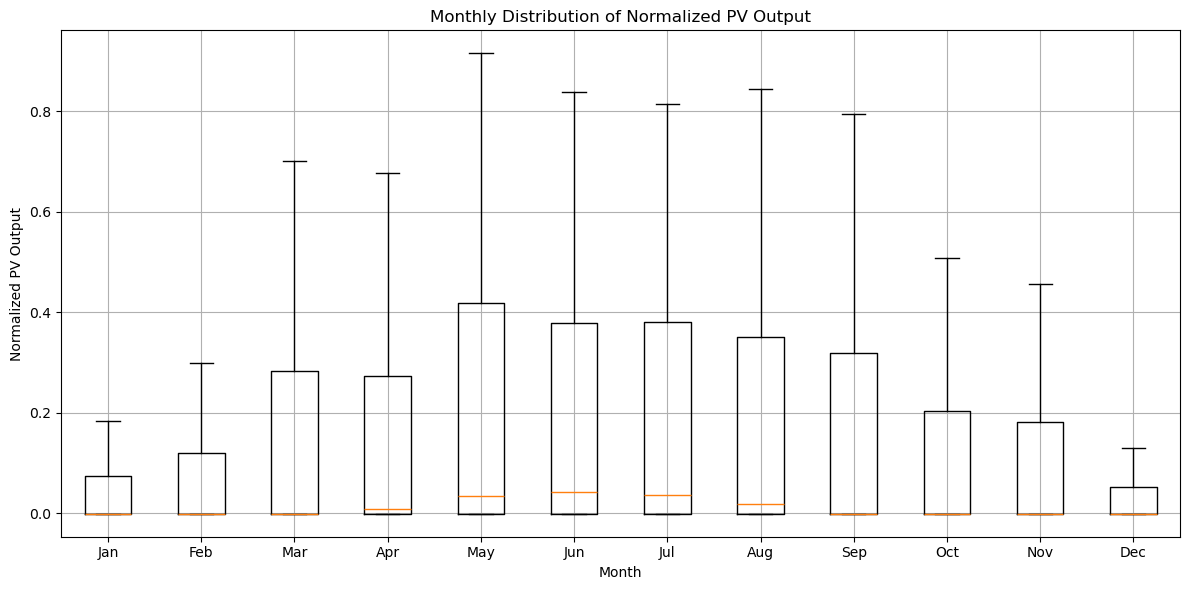

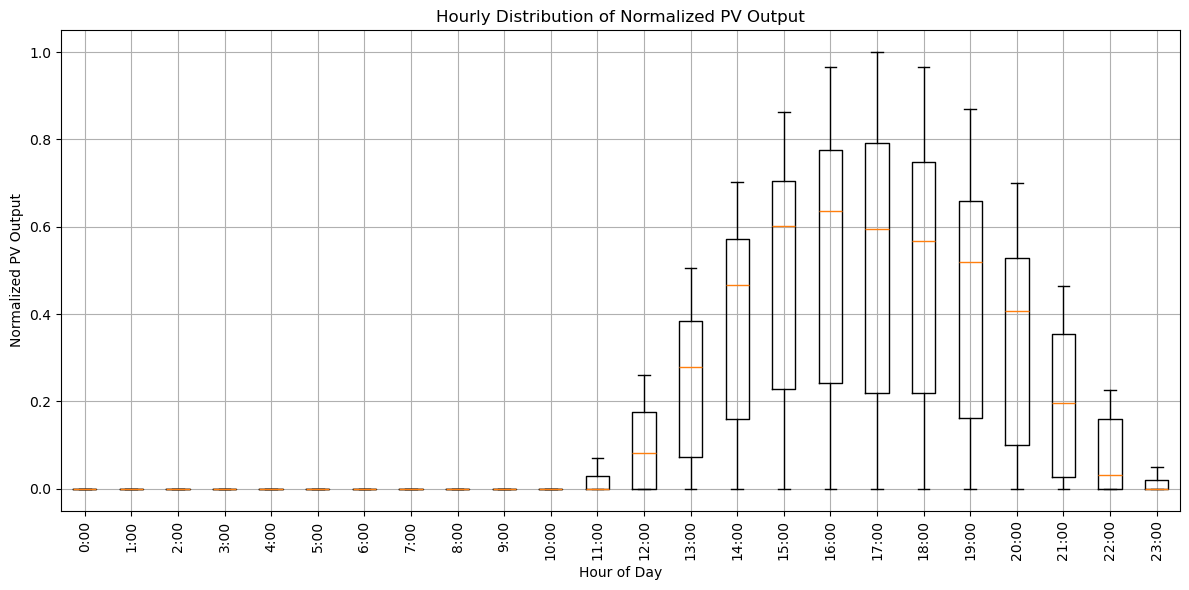

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data and set time index
df = pd.read_csv('Merged_with_pv_normalized.csv', parse_dates=['timestamp'], index_col='timestamp')

# Add “Month” and “Hour” columns
df['month'] = df.index.month
df['hour'] = df.index.hour

# 1. Monthly Distribution of Normalized PV Output
fig, ax = plt.subplots(figsize=(12, 6))
monthly_boxes = [df.loc[df['month'] == m, 'normalized_pv'].dropna() for m in range(1, 13)]
ax.boxplot(monthly_boxes, showfliers=False)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Normalized PV Output')
ax.set_title('Monthly Distribution of Normalized PV Output')
ax.grid(True)
plt.tight_layout()
plt.show()

# 2. Hourly Distribution of Normalized PV Output
fig, ax = plt.subplots(figsize=(12, 6))
hourly_boxes = [df.loc[df['hour'] == h, 'normalized_pv'].dropna() for h in range(24)]
ax.boxplot(hourly_boxes, showfliers=False)
ax.set_xticks(range(1, 25))
ax.set_xticklabels([f'{h}:00' for h in range(24)], rotation=90)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Normalized PV Output')
ax.set_title('Hourly Distribution of Normalized PV Output')
ax.grid(True)
plt.tight_layout()
plt.show()
